# TimeSeries Anamoly Detection Using Keras on the Dow Jones Since 1980

First we import the necessary libraries we need to perform the analysis on the data.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)


2023-01-20 20:41:10.401288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow version: 2.11.0


Importing the data from the csv file which was downloaded from the Historical database on YahooFinance.

We then print of the head and shape of the data to get an insight into the data we are working with.

In [2]:
df = pd.read_csv('DowJones.csv', parse_dates=['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-01-21,157.350006,157.350006,157.350006,157.350006,157.350006,0
1,1980-01-22,156.919998,156.919998,156.919998,156.919998,156.919998,0
2,1980-01-23,158.500000,158.500000,158.500000,158.500000,158.500000,0
3,1980-01-24,159.240005,159.240005,159.240005,159.240005,159.240005,0
4,1980-01-25,159.699997,159.699997,159.699997,159.699997,159.699997,0


In [3]:
df.shape

(10841, 7)

We then preprocess and prepare the data by splitting it into test and train.

In [4]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(8672, 7) (2169, 7)


We then use Standard Scaler from the sklearn preprocessing library which standardizes features by removing the mean and scaling to unit variance.

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['Adj Close']])

train['Adj Close'] = scaler.transform(train[['Adj Close']])
test['Adj Close'] = scaler.transform(test[['Adj Close']])

We then create a function which returns a 2D array.

In [6]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

We then train the data splits

In [7]:
time_steps = 30

X_train, y_train = create_dataset(train[['Adj Close']], train.Close, time_steps)
X_test, y_test = create_dataset(test[['Adj Close']], test.Close, time_steps)

print(X_train.shape)

(8642, 30, 1)


In [8]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

This is where we import the Keras libraries which will be used to build an LSTM Autoencoder.
Sequential is imported as a model which is used to organise the Keras layers in sequential order.
From the Keras Layers library we will use Dense, LSTM, Dropout, RepeatVector and TimeDistributed.

Keras Dense layer is the layer that contains all the neurons that are deeply connected within themselves.
The Long Short-Term Memory Layer which is used to optimize performance.
The Dropout Layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. The rate in the model below is set to 0.2. Dropout is used twice in this sequential model.
Repeat Vector is used to repeat input a set number of times.
The TimeDistributed Layer allows us to apply a layer to every temporal slice of an input.

Each Layer will be essential in creating a LSTM Autoencoder and you will see from the model below that we are using Sequential to sequence the layers.

A summary of the model is printed below where you can clearly see the layer type, output shape and param numbers.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))                 
])

model.compile(loss='mae', optimizer='adam')
model.summary()

2023-01-20 20:41:44.002995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            129       
 ibuted)                                                

We now create Keras callback where we use EarlyStopping setting patience to 3 while monitoring val_loss. If the network does not improve for 3 consecutive epochs the training process will stop.

Setting the number of epochs is important, as the higher the number of epochs the more accurate the training. We have set the epochs to 50, while this make take a significant amount of time to run, it will provide the most accurate training. This will improve the model.

In [10]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks = [es],
    shuffle=False
)

244/244 [==============================] - 27s 83ms/step - loss: 1226.1407 - val_loss: 3194.4873


We will not plot the training loss and val_loss below. The val_loss is seen to be higher than the training loss.

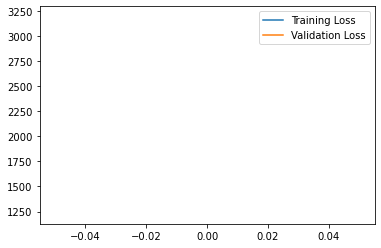

In [11]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

We now use model.predict() to predict the anomlay in our data by calculating the mean absolute error on the training data.

In [12]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

271/271 [==============================] - 10s 32ms/step


Here we use a displot to visualise the distribution loss of training mean absolute error.

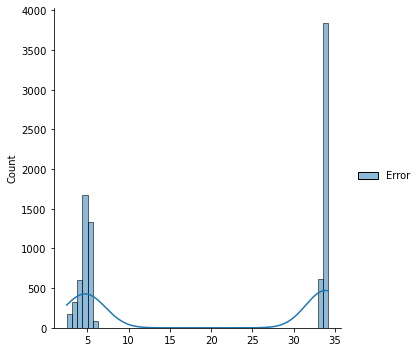

In [13]:
sns.displot(train_mae_loss, bins=50, kde=True);

In [14]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

67/67 [==============================] - 3s 37ms/step


/Users/Willie/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


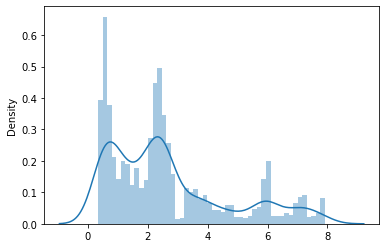

In [15]:
sns.distplot(test_mae_loss, bins=50, kde=True);

Finally we will build a data frame which contains anomaly and loss values. This will detect if a value in the data frame is an anomaly or not.

In [17]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].Close

We print the head of the dataframe to see the data and the column 'anomaly' which is a boolean value showcasing if that particular closing price is an anomaly or not.

In [18]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,Date,Open,High,Low,Close,Adj Close,Volume,loss,threshold,anomaly,close
8702,2014-07-22,4444.939941,4464.129883,4443.350098,4456.020020,2.749144,1724440000,2.832170,0.65,True,4456.020020
8703,2014-07-23,4468.160156,4480.729980,4457.950195,4473.700195,2.765211,1909810000,2.825829,0.65,True,4473.700195
8704,2014-07-24,4481.609863,4485.500000,4465.939941,4472.109863,2.763766,1935090000,2.821500,0.65,True,4472.109863
8705,2014-07-25,4448.060059,4457.950195,4430.430176,4449.560059,2.743273,1711430000,2.815345,0.65,True,4449.560059
8706,2014-07-28,4451.120117,4455.390137,4413.919922,4444.910156,2.739047,1783250000,2.812607,0.65,True,4444.910156


This is an example of building a functioning model for Anomaly Detection in Time Series using Keras.